<h2> <u>Mount Google drive folder</u> </h2>


In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/ML_workshop

/content/drive/My Drive/ML_workshop


In [4]:
ls

deep_learning/  machine_learning/


## PART D: Training a state-of-the-art cardiac segmenter

In this part of the tutorial we will train a slice-by-slice cardiac segmenter based on deep convolutional neural networks. On the way we will learn about more operations such as max pooling and tansposed convolutions. 

**Cardiac segmentation** is an important tool for calculating biomarkers such as ventricular ejection fraction or myocardial volume, which is used to diagnose diseases and measure disease progression. It also has significance for population studies which help to get better insights into normal and diseased cardiac function. 

Since cardiac segmentation is a very tedious task there is significant interest in automatic methods. In the following, we will program a deep convolutional neural network, which can automatically segment the myocardial muscle and the lumen of the left and right ventricles. The network we develop performs very close to the state-of-the-art in this field. 

We will implement a state-of-the-art segmentation network called the U-Net. The main purpose of this section is to show you how different neural network layers can be combined like building blocks to create architectures and how deep networks process large image data. For this purpose, we will use predefined layer functions that are basically built from the components you saw in the first parts of this tutorial. 

We will give an intuition for each of the components but if you are interested in understanding the components of deep convolutional neural networks better (now or in the future) you can have a look at these [lecture slides](https://git.ee.ethz.ch/baumgach/deep-learning-lecture/blob/master/pres.pdf), or use some of the many resources on the web such as the [Stanford CS231n lecture](http://cs231n.stanford.edu/). However, going into the details of all of them would not be feasible in a single tutorial. 

First let us have a closer look at the data for this part of the tutorial. 

### Loading python modules and preparing the data

Import the required packages and the ACDC cardiac segmentation challenge data. 

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

config=tf.ConfigProto()
config.gpu_options.allow_growth=True
config.allow_soft_placement=True

import numpy as np
import matplotlib.pyplot as plt

# Import acdc_data (need to add the lib package to the system path)
import os
import sys
module_path = os.path.abspath(os.path.join('.', './deep_learning/lib'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
# Now we can import the module
import acdc_data

Instructions for updating:
non-resource variables are not supported in the long term


Next, we define a few helper functions that we will use below. 

In [6]:
def plot_batch(X_b, cmap='gray'):
    
    # Plot a mini batch of images or segmentations
    
    plt.figure(figsize=(16, 14))
    N = X_b.shape[0]
    
    for n in range(N):
                
        plt.subplot(1,N,n+1)
        plt.imshow(np.squeeze(X_b[n,...]), cmap=cmap)
    
    plt.show()

def validate(data, sess, loss_pl, X_pl, Y_pl, train_pl, batch_size=5):
    
    # iterate over all samples in a dataset and evaluate a given loss placeholder
    
    total_loss = 0
    total_points = 0
    for val_batch in data.iterate_batches(batch_size):
        
        X_b, Y_b = val_batch
        total_loss += sess.run(loss_pl, feed_dict={X_pl: X_b, Y_pl: Y_b, train_pl: False})
        total_points += 1
        
    return total_loss / total_points

Let's get a sample batch of 1 training image and 1 ground-truth mask to analyse the data and define the image sizes etc. 

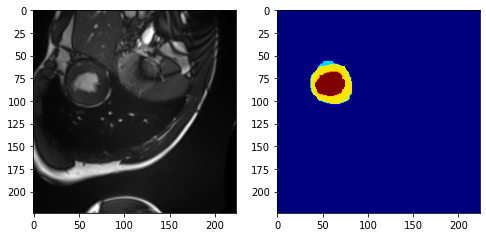

Image shape (first dimension is the batch size)
(1, 224, 224)
Mask shape (first dimension is the batch size)
(1, 224, 224)
Shape summary:
 - Images and masks have dimesions 224x224
 - The input images have 1 colour channels
 - The target masks have 4 labels


In [7]:
img, mask = acdc_data.train.next_batch(1)

fig = plt.figure(figsize=(8,16))
plt.subplot(121)
plt.imshow(np.squeeze(img), cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(mask), cmap='jet')
plt.show()

input_channels = 1
output_channels = 4
image_size_x = img.shape[1]
image_size_y = img.shape[2]

print('Image shape (first dimension is the batch size)')
print(img.shape)  
print('Mask shape (first dimension is the batch size)')
print(mask.shape)

print('Shape summary:')
print(' - Images and masks have dimesions %dx%d' % (image_size_x, image_size_y))
print(' - The input images have %d colour channels' % input_channels)
print(' - The target masks have %d labels' % output_channels)

The label colour correspond to the following structures:
 - Dark Blue: Background (label 0)
 - Light Blue: Right ventricle (label 1)
 - Yellow: Myocardium (label 2)
 - Red: Left Ventricle (label 3)
 
If you randomly got an image without some of the labels rerun the block above. 


### Building the U-NET architecture 

The image below shows the architecture of the network we will be building which was published by [Ronneberger et al.](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) in 2015. (We will be using a different image size, however.)

<img src="../images/unet_architecture.png" style="width: 800px;"/> 

We will be using a number of basic network components for which we will briefly discuss the intuition in the following. For a more thorough explanation have a look at our [lecture slides](https://git.ee.ethz.ch/baumgach/deep-learning-lecture/blob/master/pres.pdf).  

 * **Convolution Layers** (`conv2D_layer_bn`): The basic building block of almost all state-of-the-art deep neural network architectures. Convolution layers function almost exactly as the example from the last part of the tutorial. However, the output images produced by them are not used directly, but are used as input to the next layer. The weights get tuned during training in a way that minimises the final segmentation (or sometimes classification) loss. In the last example we looked at an example with two kernels. In the U-Net every convolutional layer has many more kernels (the first one has 64 for example). The main reason why people are using convolutional layers instead of fully connected layers as we saw in part B is that they need many fewer parameters. You can get one output/activation per input image pixel with only 3x3=9 parameters. 
 * **Max Pooling Layers** (`max_pool_layer2d`): A very simple operation that downsamples the input to the layer by a factor of two. This is done by dividing the input into 2x2 cells and taking the maximimum number of each cell to create the output. 
 * **Up-conv or "Deconvolution" Layers** (`deconv2D_layer_bn`): These layers function very similar to convolution layers, however additionally they have the property that the input size is upsampled by a factor of 2. So in a way, they do the opposite of max pooling layers. 
 * **Skip connections** (`concat`): If you have a close look at the architecture above you will notice that the input to the network first gets downsampled 4 times by max-pooling layers and then upsampled 4 times by Up-conv layers. After downsampling the image by a factor of $2^4=16$, so the activations have a size of only 16x16 in the middle "bottle-neck" of the network. This means most spatial information was lost and it would be impossible to to know exactly where a segmentation boundary should be by upsampling these activations. To reintroduce the spatial information to the upsampling path, the downsampling activations are *skipped forward* in regular intervals (gray arrows.)
 * **Batch normalisation**: In order to accelerate training, all convolutional and deconvolutional layers get normalised in a special way. This was not part of the original U-Net paper, however, this sort of normalisation has been shown to greatly accelerate network training. 
 
All of these layers and operations are implemented in `tensorflow`. You simply need to write a wrapper function for them once, and then you can use them like blocks in a lego set in the future. These functions are defined in the `lib/tfwrapper` folder of this tutorial if you want to have a look. There are also frameworks such as [keras](https://keras.io/) that build on `tensorflow` but already have such wrapper functions pre-implemented. 

Now let us start building the network. 

### Creating appropriate placeholders for the input  and target data

First, we need to generate placeholders for the input to the network, much like we did for part of this tutorial. Specifically, we need placeholders for the network input image $X$ for the target segmentation map $Y$. We also fix the `batch_size` in this example, because it will make it easier to get the dimensions right in the transposed convolutions.


In [8]:
tf.reset_default_graph() # This is necessary if you need to rerun code in the tutorial

batch_size = 5

X_pl = tf.placeholder(tf.float32, [batch_size, image_size_x, image_size_y], name='X')
Y_pl = tf.placeholder(tf.uint8, [batch_size, image_size_x, image_size_y], name='Y')

Note that the mask data has four labels which are encoded by integers from 0 to 3. As a consequence the `Y_pl` placeholder has only 3 dimensions. However, for neural network training it is beneficial to use the so-called **one hot notation**. This adds another channel to the end of the data which is either 1 or 0 depending on the presence or absence of a label at that pixel. 

That is to say, for an example pixel that has label 2 the one hot encoding would be [0, 0, 1, 0]. Label 0 would be encoded as [1, 0, 0, 0]. We could manually transform the mask data to the one hot format before training. However, we can also elegantly incorporate this into tensorflow by creating a new placeholder of the correct shape via the function `tf.one_hot(input_placeholder, depth=number_of_labels)`. 

Furthermore, also the image data only has 3 dimensions because there is only one colour channel. However, since tensorflow convolutions work on 4D tensors we need to make the colour channel explicit as an additional dimension. For this purpose we can use the `tf.expand_dims(input_placeholder, axis=position_of_new_axis)` function. For adding a dimensions to the end of a tensor we can set `axis=-1`. 

Below, create new placeholders for both X, and Y. 

In [9]:
### IMPLMENT THE FOLLOWING ###
Y_onehot_pl = tf.one_hot(Y_pl, depth=4)
X_extra_dim_pl = tf.expand_dims(X_pl, axis=3)
##############################

print('Shape of Y_onehot_pl is')
print(Y_onehot_pl.get_shape().as_list())

print('Shape of X_extra_dim_pl is')
print(X_extra_dim_pl.get_shape().as_list())

Shape of Y_onehot_pl is
[5, 224, 224, 4]
Shape of X_extra_dim_pl is
[5, 224, 224, 1]


Before moving on, verify that the shape of `Y_onehot_pl` is `[batch_size, image_size_x, image_size_y, num_labels]`, and the size of `X_extra_dim` is `[batch_size, image_size_x, image_size_y, num_colour_channels]`. 

### Implementing the network architecture

In the following we will implement the U-Net architecture from the image above using the predefined wrapper functions mentioned earlier. Can you see how this corresponds to the picture above? What should the missing line be?

In [10]:
from tfwrapper import layers

train_pl = tf.placeholder(tf.bool, shape=[])  # Batch normalisation needs to know if you are training or testing
                                              # so we need a placeholder for this

conv1_1 = layers.conv2D_layer_bn(X_extra_dim_pl, 'conv1_1', num_filters=64, kernel_size=(3, 3), training=train_pl)
conv1_2 = layers.conv2D_layer_bn(conv1_1, 'conv1_2', num_filters=64, kernel_size=(3, 3), training=train_pl)

pool1 = layers.max_pool_layer2d(conv1_2)

conv2_1 = layers.conv2D_layer_bn(pool1, 'conv2_1', num_filters=128, kernel_size=(3, 3), training=train_pl)
conv2_2 = layers.conv2D_layer_bn(conv2_1, 'conv2_2', num_filters=128, kernel_size=(3, 3), training=train_pl)

pool2 = layers.max_pool_layer2d(conv2_2)

conv3_1 = layers.conv2D_layer_bn(pool2, 'conv3_1', num_filters=256, kernel_size=(3, 3), training=train_pl)
conv3_2 = layers.conv2D_layer_bn(conv3_1, 'conv3_2', num_filters=256, kernel_size=(3, 3), training=train_pl)

### COMPLETE THE MISSING LAYER ###
pool3 = layers.max_pool_layer2d(conv3_2)
###

conv4_1 = layers.conv2D_layer_bn(pool3, 'conv4_1', num_filters=512, kernel_size=(3, 3), training=train_pl)
conv4_2 = layers.conv2D_layer_bn(conv4_1, 'conv4_2', num_filters=512, kernel_size=(3, 3), training=train_pl)

upconv3 = layers.deconv2D_layer_bn(conv4_2, name='upconv3', kernel_size=(4, 4), strides=(2, 2), num_filters=256, training=train_pl)
concat3 = tf.concat([conv3_2, upconv3], axis=3, name='concat3')

conv5_1 = layers.conv2D_layer_bn(concat3, 'conv5_1', num_filters=256, kernel_size=(3, 3), training=train_pl)
conv5_2 = layers.conv2D_layer_bn(conv5_1, 'conv5_2', num_filters=256, kernel_size=(3, 3), training=train_pl)

upconv2 = layers.deconv2D_layer_bn(conv5_2, name='upconv2', kernel_size=(4, 4), strides=(2, 2), num_filters=128, training=train_pl)
concat2 = tf.concat([conv2_2, upconv2], axis=3, name='concat2')

conv6_1 = layers.conv2D_layer_bn(concat2, 'conv6_1', num_filters=128, kernel_size=(3, 3), training=train_pl)
conv6_2 = layers.conv2D_layer_bn(conv6_1, 'conv6_2', num_filters=128, kernel_size=(3, 3), training=train_pl)

upconv1 = layers.deconv2D_layer_bn(conv6_2, name='upconv1', kernel_size=(4, 4), strides=(2, 2), num_filters=64, training=train_pl)
concat1 = tf.concat([conv1_2, upconv1], axis=3, name='concat1')

conv7_1 = layers.conv2D_layer_bn(concat1, 'conv7_1', num_filters=64, kernel_size=(3, 3), training=train_pl)
conv7_2 = layers.conv2D_layer_bn(conv7_1, 'conv7_2', num_filters=64, kernel_size=(3, 3), training=train_pl)

logits_pl = layers.conv2D_layer_bn(conv7_2, 'pred', num_filters=output_channels, kernel_size=(1,1), activation=layers.linear_activation, training=train_pl)

INFO:tensorflow:Summary name conv1_1_w:0 is illegal; using conv1_1_w_0 instead.
INFO:tensorflow:Summary name conv1_1_b:0 is illegal; using conv1_1_b_0 instead.
INFO:tensorflow:Summary name conv1_2_w:0 is illegal; using conv1_2_w_0 instead.
INFO:tensorflow:Summary name conv1_2_b:0 is illegal; using conv1_2_b_0 instead.
INFO:tensorflow:Summary name conv2_1_w:0 is illegal; using conv2_1_w_0 instead.
INFO:tensorflow:Summary name conv2_1_b:0 is illegal; using conv2_1_b_0 instead.
INFO:tensorflow:Summary name conv2_2_w:0 is illegal; using conv2_2_w_0 instead.
INFO:tensorflow:Summary name conv2_2_b:0 is illegal; using conv2_2_b_0 instead.
INFO:tensorflow:Summary name conv3_1_w:0 is illegal; using conv3_1_w_0 instead.
INFO:tensorflow:Summary name conv3_1_b:0 is illegal; using conv3_1_b_0 instead.
INFO:tensorflow:Summary name conv3_2_w:0 is illegal; using conv3_2_w_0 instead.
INFO:tensorflow:Summary name conv3_2_b:0 is illegal; using conv3_2_b_0 instead.
INFO:tensorflow:Summary name conv4_1_w:0

You can ignore the `INFO` warnings. In case you need to run the above block multiple times, you need to start from the cell with the `tf.reset_default_graph()` command. Otherwise, will complain about existing variable names. 

### Implementing the cross entropy loss function for multiple classes

In the case of multiple output classes like in our example of cardiac segmentation instead of the sigmoid function from part B, usually the [**softmax function**](https://en.wikipedia.org/wiki/Softmax_function) is used instead. The softmax function squashes the outputs so that they are positive and sum up to one. This means they can be interpreted as probabilities of it being a specific class. The weights $w_{ij}$ and biases $b_i$ is what we optimise in the learning process. 

Now which sort of loss should we choose? It turns out that the segmentation of an image is actually only a bunch of classification tasks. We need to predict the correct class for each pixel $i$ of the input image. As we saw earlier, the standard loss for classifciation tasks is the **cross entropy loss**. Because we no longer only have two classes and also each image consists of multiple classification targets (one label per pixel) we need to rewrite the cross entropy loss in the following way:

$$  L(\phi) = - \frac{1}{N\cdot P} \sum_x \sum_i y_i(x) \text{log}(\hat{y}_i(x)) $$

where $y(x)$ is the ground truth label in one-hot notation of any pixel $x$ in the dataset and $\hat{y}(x)$ is the softmax prediction of that pixel. The outer sum over $x$ is over all pixels in the dataset. The inner sum over $l$ is over the indices of the one-hot vectors. 

If $y_i(x)$ is 1, $\hat{y}_i = 1$ minimises this term because $log(1)=0$. Predictions smaller than one will produce negative numbers, increasing the loss. Remember that the softmax produces numbers between 0 and 1. Verify this by inspecting the equation.

As usual tensorflow provides us with a convienient function to calculate the cross entropy. Namely, `tf.nn.softmax_cross_entropy_with_logits_v2(logits=network_output_logits, labels=groundtruth_one_hot_labels)`. However, as is evident from the namethe function takes the output **logits** as the input rather than the softmax. The logits are the values right before the softmax. This is done for efficiency reasons, the softmax is computed internally inside the function. Below, define the loss for the network and feed it to the training operation. 

In [11]:
### IMPLEMENT THIS ###
total_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits_pl, labels=Y_onehot_pl)
###

loss_pl = tf.reduce_mean(total_cross_entropy)  

optimiser = tf.train.AdamOptimizer(0.1)  
train_op = optimiser.minimize(loss_pl)

Let us also create a placeholder to convert the softmax prediction back into a mask of integers. This can be done by taking the argmax of the softmax predictions along the last axis, i.e. the one we added in the `tf.one_hot` function. 

In [12]:
predicted_softmax_pl = tf.nn.softmax(logits_pl, axis=-1)
predicted_mask_pl = tf.argmax(predicted_softmax_pl, axis=-1)

### Training the network 

Note that it is impossible to minimise the loss function $L$ above with all the data simultanously. The dataset is much too large to fit onto the GPU together with all the network weights and feature maps. 

Instead in deep learning applications the networks are typically trained in **mini batches**. This means rather than calculating the loss $L$ and the gradients for the updates of the weights and biases on *all* of the data we calculate it on a small part of the data. Namely, we choose a subset with a certain **batch size**, in our case 5 images. 

This will produce inaccurate gradient estimates, but has the advantage of fitting into GPU memory and also providing much faster gradient updates. It turns out that the poor gradient estimates are actually an advantage as well because they prevent the optimiser from getting stuck in local minima. 

As before in part B, the module `acdc_data` already has a function that splits the entire dataset into random mini batches and provides them batch by batch to a for loop: `acdc_data.train.iterate_batches(batch_size)`. This means we can implement the training operation in a for loop similar to part C of this practical. 

In the training loop below implement the inner for loop and run the training operation in the `tf.Session()`. Note that for now we only train for **two** epochs. After that we will perform some evaluations before training the model to completion. This will take about 12 minutes so feel free to go grab another coffee or have a short break. 

Step: 0, Loss: 1.386292


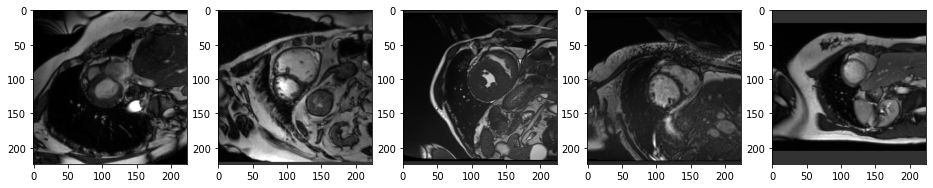

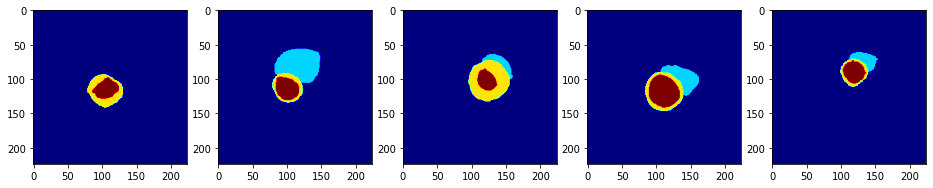

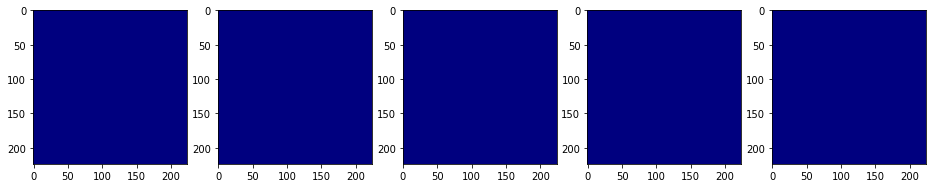

Step: 5, Loss: 0.827168
Step: 10, Loss: 0.459788
Step: 15, Loss: 0.339931
Step: 20, Loss: 0.220131
Step: 25, Loss: 0.273614
Step: 30, Loss: 0.263551
Step: 35, Loss: 0.178479
Step: 40, Loss: 0.256030
Step: 45, Loss: 0.268170
Step: 50, Loss: 0.250020


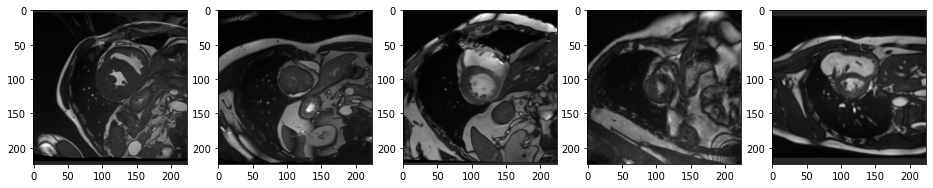

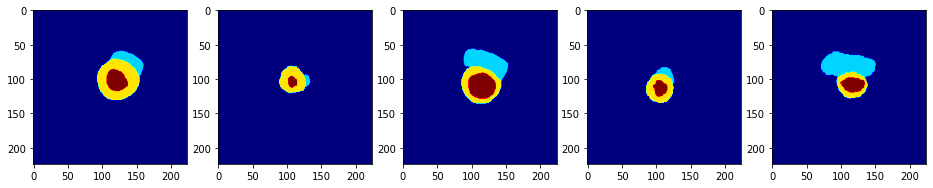

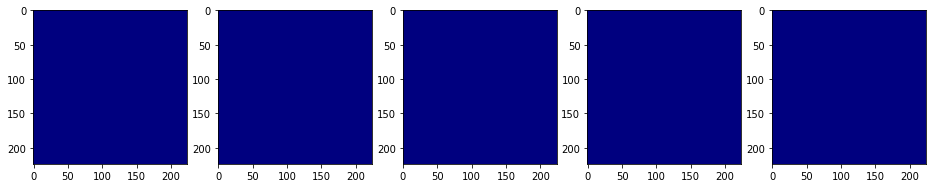

Step: 55, Loss: 0.157626
Step: 60, Loss: 0.227793
Step: 65, Loss: 0.246606
Step: 70, Loss: 0.205754
Step: 75, Loss: 0.149389
Step: 80, Loss: 0.194388
Step: 85, Loss: 0.164501
Step: 90, Loss: 0.106973
Step: 95, Loss: 0.150214
Step: 100, Loss: 0.159630


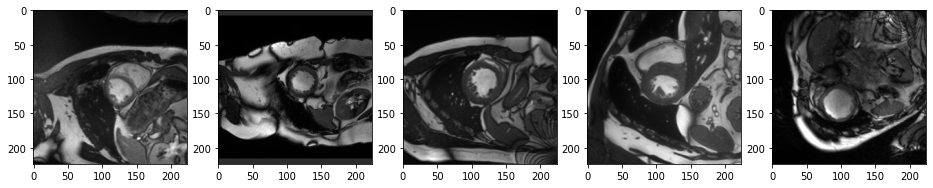

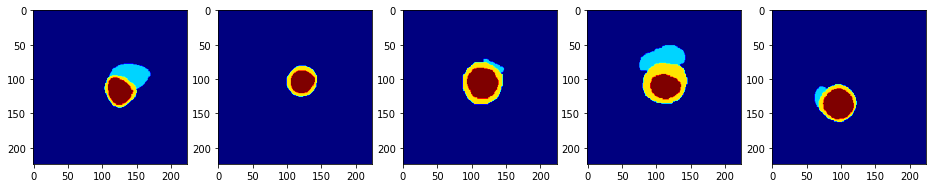

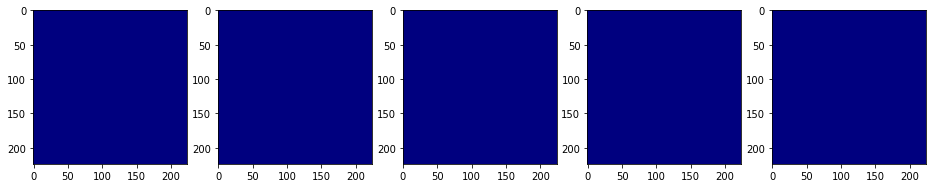

Step 100 (epoch 0)
 - Validation Loss: 0.194838
Step: 105, Loss: 0.159025
Step: 110, Loss: 0.261282
Step: 115, Loss: 0.179624
Step: 120, Loss: 0.195756
Step: 125, Loss: 0.211159
Step: 130, Loss: 0.162728
Step: 135, Loss: 0.179710
Step: 140, Loss: 0.190047
Step: 145, Loss: 0.190129
Step: 150, Loss: 0.115397


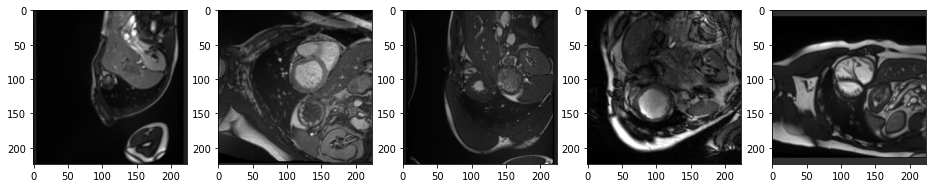

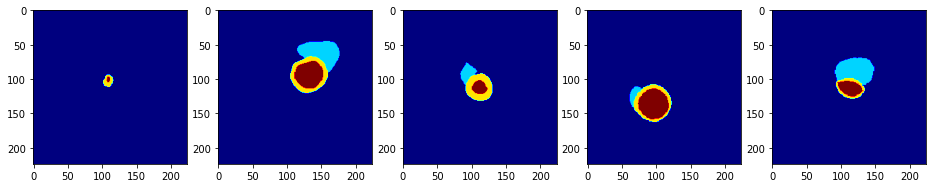

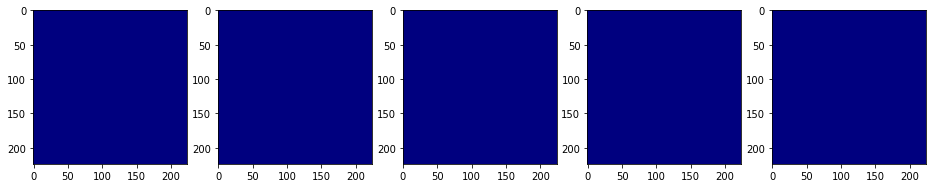

Step: 155, Loss: 0.151077
Step: 160, Loss: 0.211965
Step: 165, Loss: 0.123845
Step: 170, Loss: 0.199729
Step: 175, Loss: 0.192984
Step: 180, Loss: 0.159290
Step: 185, Loss: 0.143813
Step: 190, Loss: 0.149629
Step: 195, Loss: 0.102065
Step: 200, Loss: 0.194588


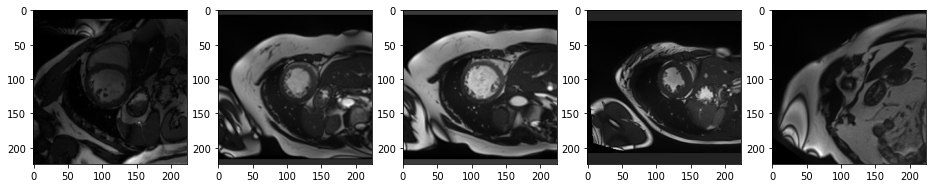

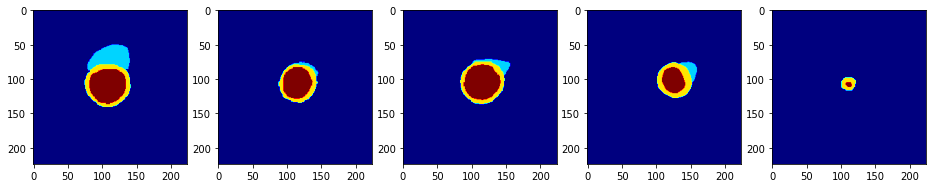

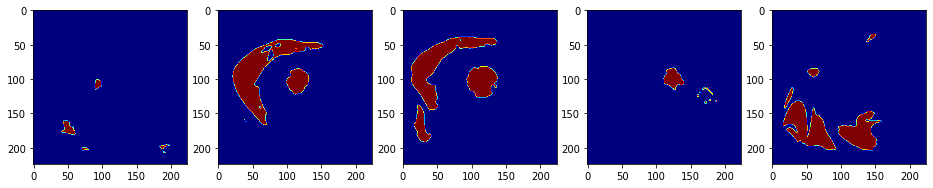

Step 200 (epoch 0)
 - Validation Loss: 0.225496
Step: 205, Loss: 0.135830
Step: 210, Loss: 0.144960
Step: 215, Loss: 0.176215
Step: 220, Loss: 0.142499
Step: 225, Loss: 0.170355
Step: 230, Loss: 0.122073
Step: 235, Loss: 0.125133
Step: 240, Loss: 0.141341
Step: 245, Loss: 0.225636
Step: 250, Loss: 0.201077


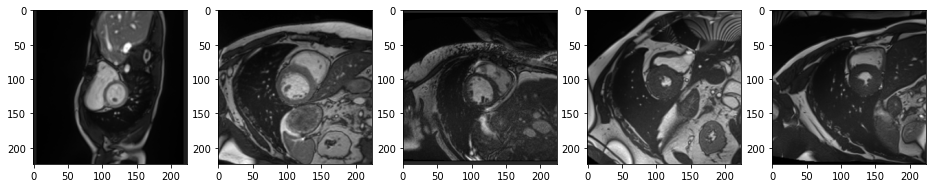

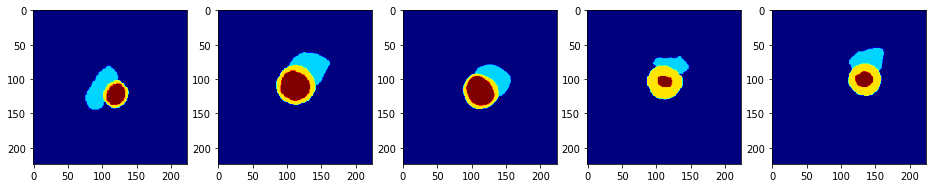

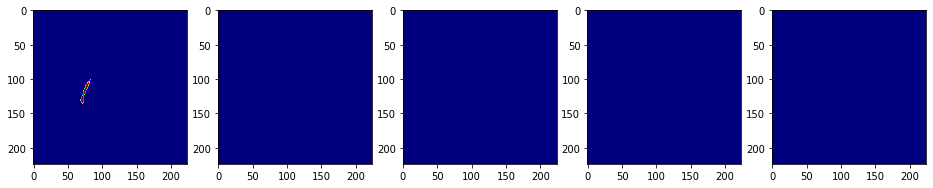

Step: 255, Loss: 0.103431
Step: 260, Loss: 0.144162
Step: 265, Loss: 0.100343
Step: 270, Loss: 0.169987
Step: 275, Loss: 0.104137
Step: 280, Loss: 0.173115
Step: 285, Loss: 0.106163
Step: 290, Loss: 0.136511
Step: 295, Loss: 0.148050
Step: 300, Loss: 0.172357


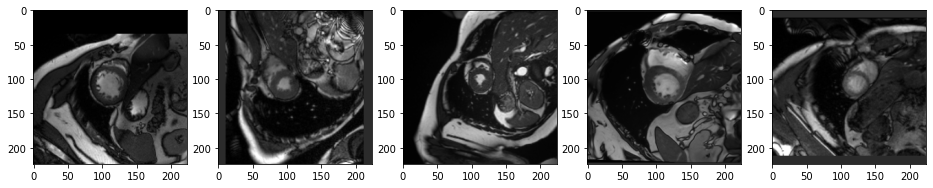

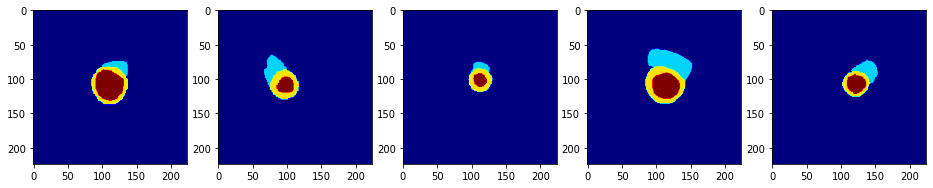

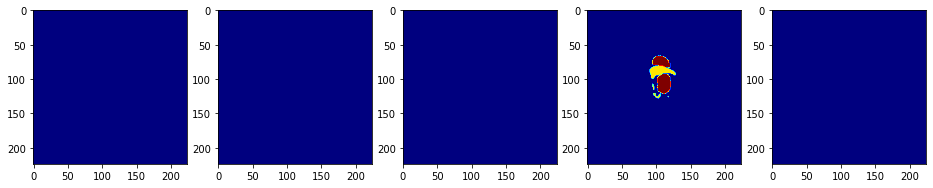

Step 300 (epoch 1)
 - Validation Loss: 0.144792
Step: 305, Loss: 0.111123
Step: 310, Loss: 0.130773
Step: 315, Loss: 0.163703
Step: 320, Loss: 0.128514
Step: 325, Loss: 0.104478
Step: 330, Loss: 0.109465
Step: 335, Loss: 0.165579
Step: 340, Loss: 0.139692
Step: 345, Loss: 0.142290
Step: 350, Loss: 0.112193


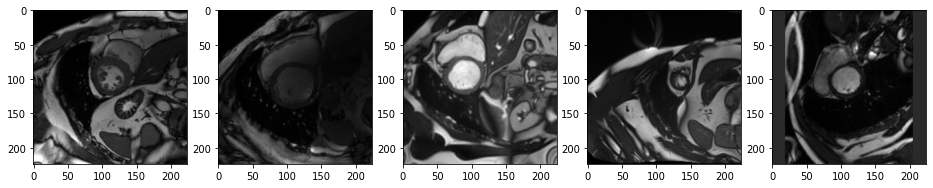

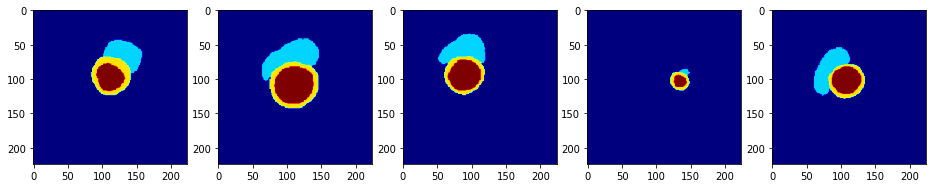

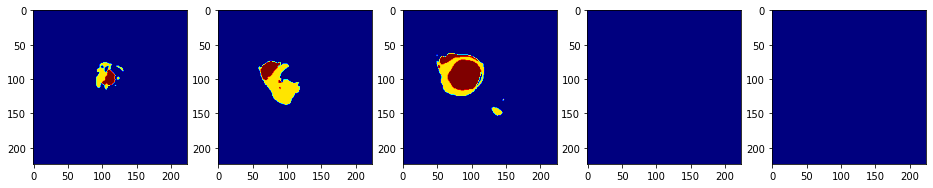

Step: 355, Loss: 0.166071
Step: 360, Loss: 0.089687
Step: 365, Loss: 0.134270
Step: 370, Loss: 0.129846
Step: 375, Loss: 0.098482
Step: 380, Loss: 0.106583
Step: 385, Loss: 0.107626
Step: 390, Loss: 0.112842
Step: 395, Loss: 0.124211
Step: 400, Loss: 0.109256


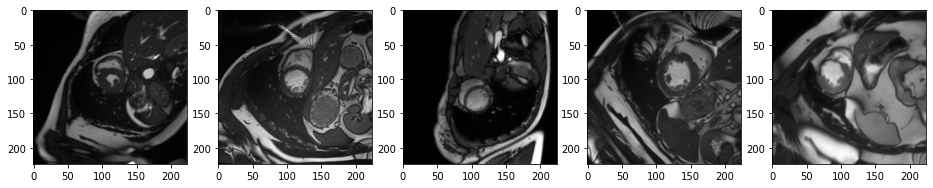

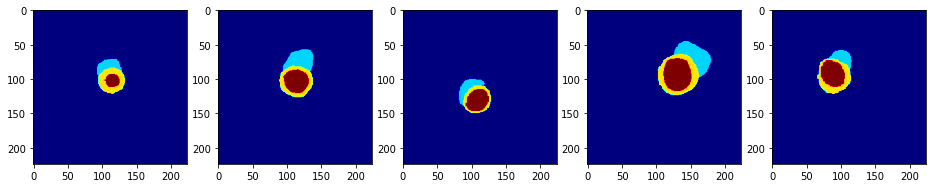

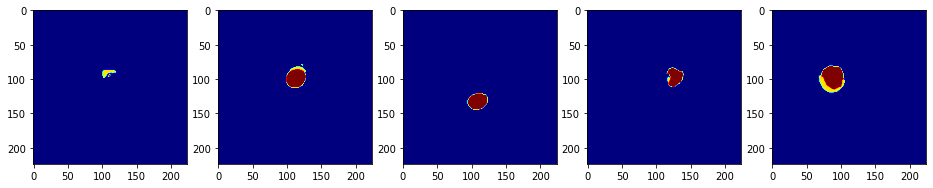

Step 400 (epoch 1)
 - Validation Loss: 0.136165
Step: 405, Loss: 0.198525
Step: 410, Loss: 0.140523
Step: 415, Loss: 0.102761
Step: 420, Loss: 0.125110
Step: 425, Loss: 0.057621
Step: 430, Loss: 0.087623
Step: 435, Loss: 0.085029
Step: 440, Loss: 0.094228
Step: 445, Loss: 0.107562
Step: 450, Loss: 0.080676


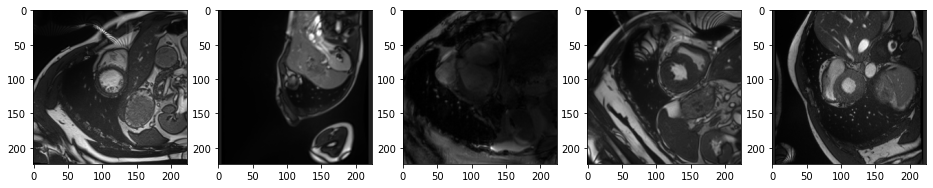

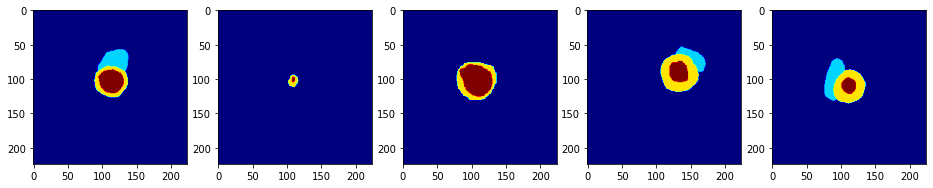

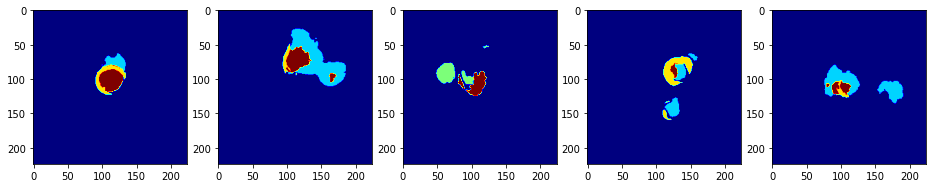

Step: 455, Loss: 0.120565
Step: 460, Loss: 0.058539
Step: 465, Loss: 0.118032
Step: 470, Loss: 0.099048
Step: 475, Loss: 0.127900
Step: 480, Loss: 0.074280
Finished optimisation!


In [13]:
# We also need an initialiser to initialise the network variables
init = tf.global_variables_initializer()

sess = tf.Session(config=config)
sess.run(init)

step = 0
for epoch in range(2):

    for batch in acdc_data.train.iterate_batches(batch_size):

        X_b, Y_b = batch
        loss, _ = sess.run([loss_pl, train_op], 
                           feed_dict={X_pl: X_b, Y_pl: Y_b, train_pl: True})  # Plug in the correct variables here

        if step % 5 == 0:
            print('Step: %d, Loss: %f' % (step, loss))
            
        if step % 50 == 0:
            
            # Every 10 steps we plot the predictions with the most recent model on a random
            # sample batch from the validation dataset
            
            X_b, Y_b = acdc_data.validation.next_batch(batch_size)
            output = sess.run(predicted_mask_pl, feed_dict={X_pl: X_b, train_pl: False})

            plot_batch(X_b)
            plot_batch(Y_b, cmap='jet')
            plot_batch(output, cmap='jet')
            
        if step % 100 == 0 and step > 0:  # don't do this for the first step
            
            # Every 10 steps we also evaluate the performance of our network on the entire validation set
            # We also evaluate the performance on the whole training set to identify overfitting. 
            
            val_loss = validate(acdc_data.validation, sess, loss_pl, X_pl, Y_pl, train_pl)
            print('Step %d (epoch %d)' % (step, epoch))
            print(' - Validation Loss: %f' % (val_loss))
            
            # we omit estimating the training loss in the interest of time
            # train_loss = validate(acdc_data.train, sess, loss_pl, X_pl, Y_pl, train_pl)
            # print(' - Training Loss: %f' % (train_loss))
        
        step += 1
        
print("Finished optimisation!")

Hopefully, you saw that already the model is starting to predict some of the structures of the heart albeit with a very low accuracy. Training the model to convergence will take at least another 3-4 hours. However, at this point we can already have a look at the generated activations maps of the different layers.

The following code retrieves the activation maps for some of the convolutional layers at each resolution stage. It displays only the first 4 activations maps for a random image from the test set. 

Go ahead and run it.

Plotting activations of layer: conv1_2
Tensor("Relu_1:0", shape=(5, 224, 224, 64), dtype=float32)


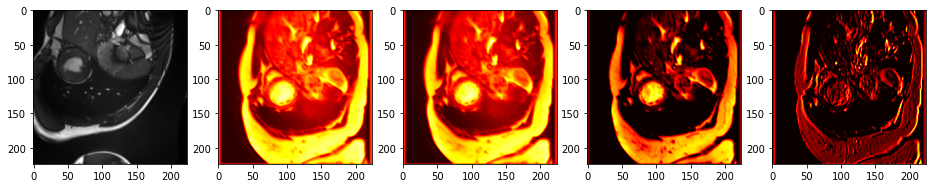

Plotting activations of layer: conv2_2
Tensor("Relu_3:0", shape=(5, 112, 112, 128), dtype=float32)


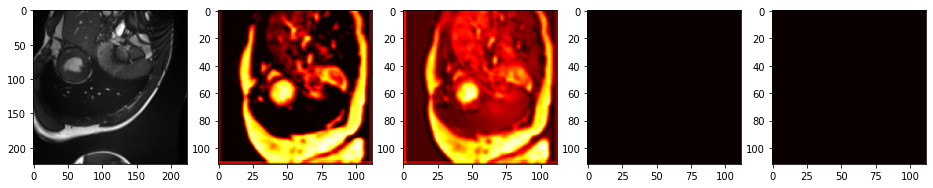

Plotting activations of layer: conv3_2
Tensor("Relu_5:0", shape=(5, 56, 56, 256), dtype=float32)


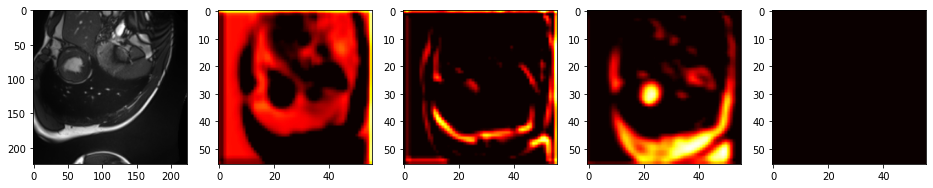

Plotting activations of layer: conv4_2
Tensor("Relu_7:0", shape=(5, 28, 28, 512), dtype=float32)


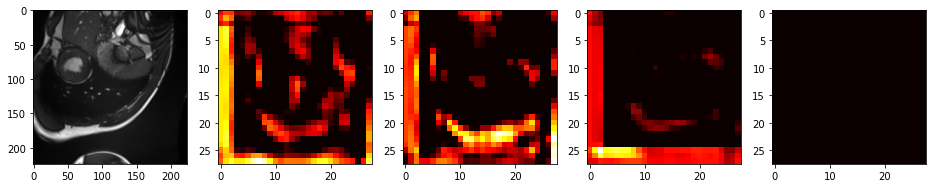

Plotting activations of layer: conv5_2
Tensor("Relu_10:0", shape=(5, 56, 56, 256), dtype=float32)


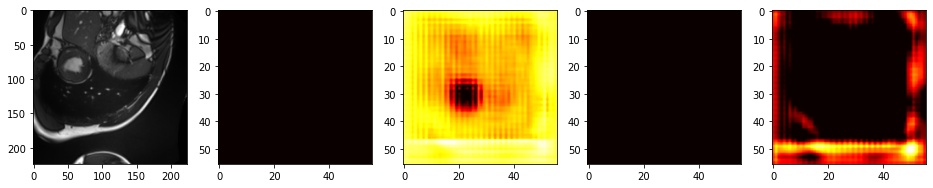

Plotting activations of layer: conv6_2
Tensor("Relu_13:0", shape=(5, 112, 112, 128), dtype=float32)


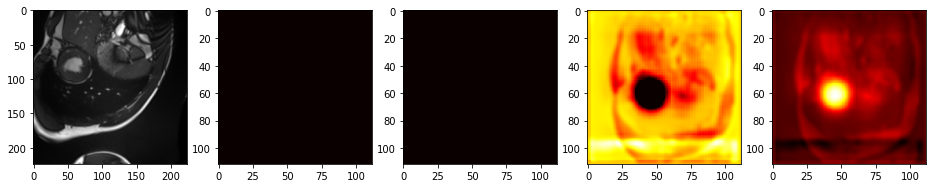

Plotting activations of layer: conv7_2
Tensor("Relu_16:0", shape=(5, 224, 224, 64), dtype=float32)


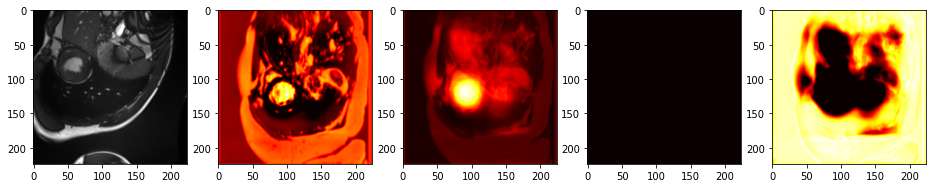

In [14]:
test_batch = acdc_data.test.next_batch(5)
img_t, mask_t = test_batch

# Get the activation maps for some specific kernels
# (feel free to check some other ones)
layer_list = [conv1_2, conv2_2, conv3_2, conv4_2, conv5_2, conv6_2, conv7_2]
name_list = ['conv1_2', 'conv2_2', 'conv3_2', 'conv4_2', 'conv5_2', 'conv6_2', 'conv7_2']

# The list can be evaluated in one go using sess.run
activation_list = sess.run(layer_list, feed_dict={X_pl: img_t, train_pl: False}) 

# In this loop for each evaluated activation we plot the input image and then 4 of the activation maps
for activation_map, layer, name in zip(activation_list, layer_list, name_list):
    
    print('Plotting activations of layer: %s' % name)
    print(layer)

    # Get the first 4 activations for the first image in the batch
    activation_subset = np.squeeze(activation_map[0,:,:,:4])
    M = activation_subset.shape[2] 
    
    # Plot input image
    plt.figure(figsize=(16,14))
    plt.subplot(1,M+1,1)
    plt.imshow(img[0,...], cmap='gray')
    
    # Plot the activatio maps
    for m in range(M):
        
        plt.subplot(1,M+1,m+2)
        plt.imshow(np.squeeze(activation_subset[:,:,m]), cmap='hot')
    plt.show()
        
# Rerun this block for different results

We can see that the activation maps start focusing on different aspects of the heart. If we train the model for longer this would be become even more pronounced. 

We can also observe how the activation maps towards the centre of the network operate at a much lower spatial resolution compared to the layers in the beginning. Perhaps the output of the conv1_2 layer will remind you of the gradient images we produced in part C of the tutorial. Indeed it is known that convolutional neural networks tend to focus on edges and other low-level features in the first few layers, while focusing on more abstract things in deeper layers. 

You may also observe that some of the feature maps remain black, i.e. equal to zero. This is probably due to some of the neurons 'dying', i.e. the weights got so small that the activation never makes it over the bias. This behaviour may have to do with the fact that we chose a very large (perhaps too large) learning rate for this tutorial.

### What to do from now?

After evaluating the activation maps above you can continue training and observe the progress. You can also train for another 2 epochs (by changing the variable below) and evaluate the change in the activation maps above. 

If you wish to do so, you can leave the network running. Google Colab allows running models on GPU for 12 hours. 

If you are interested more in deep learning, there are loads of great resources and tutorials on the internet. As mentioned before the Stanford class on [Convolutional Neural Networks for Visual Recognition (CS231n)](http://cs231n.github.io/) is a great resource, with a lot of good material, videos and text. 

Also this tutorial will remain online, if you want to go back and check something at some point. 

Lastly, you learn best by doing, so why not try a deep learning approach on one of the problems in your own research?

Step: 485, Loss: 0.065924
Step: 490, Loss: 0.165345
Step: 495, Loss: 0.084557
Step: 500, Loss: 0.097992


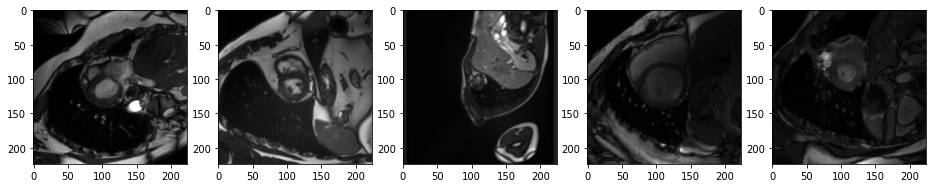

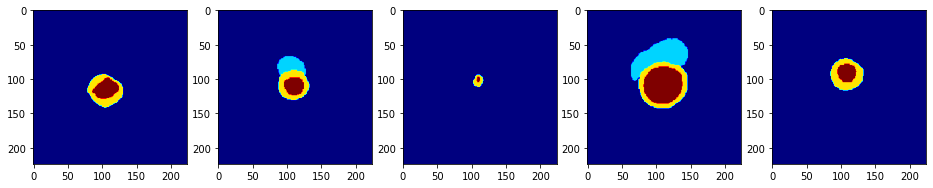

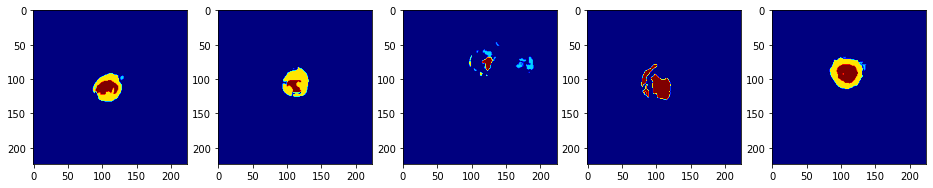

Step 500 (epoch 0)
 - Validation Loss: 0.102198
Step: 505, Loss: 0.082722
Step: 510, Loss: 0.097844
Step: 515, Loss: 0.064752
Step: 520, Loss: 0.102133
Step: 525, Loss: 0.058148
Step: 530, Loss: 0.060328
Step: 535, Loss: 0.065639
Step: 540, Loss: 0.065791
Step: 545, Loss: 0.067257
Step: 550, Loss: 0.078092


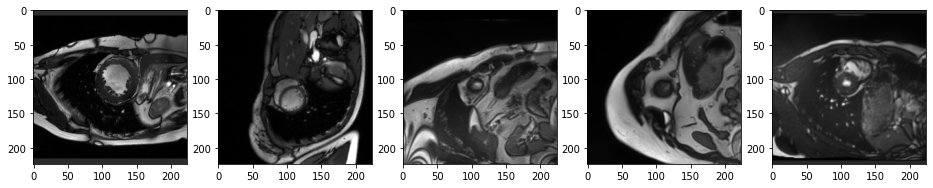

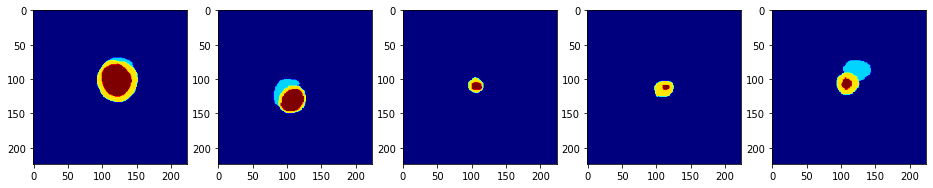

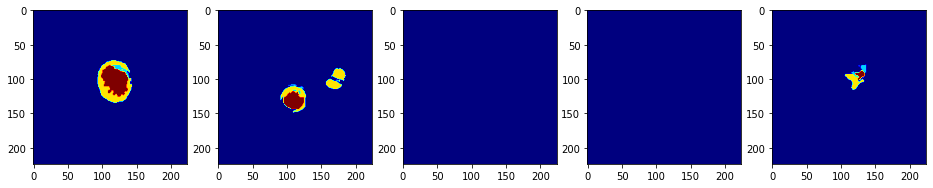

Step: 555, Loss: 0.068297
Step: 560, Loss: 0.061236
Step: 565, Loss: 0.068200
Step: 570, Loss: 0.131843
Step: 575, Loss: 0.067110
Step: 580, Loss: 0.099881
Step: 585, Loss: 0.055099
Step: 590, Loss: 0.067653
Step: 595, Loss: 0.074623
Step: 600, Loss: 0.094407


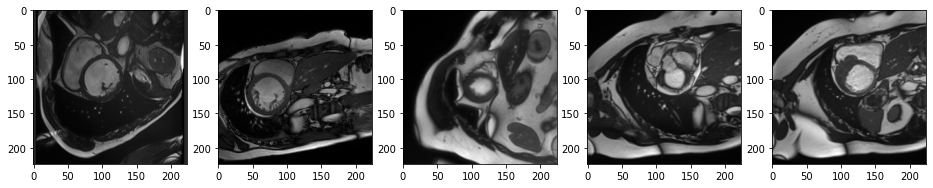

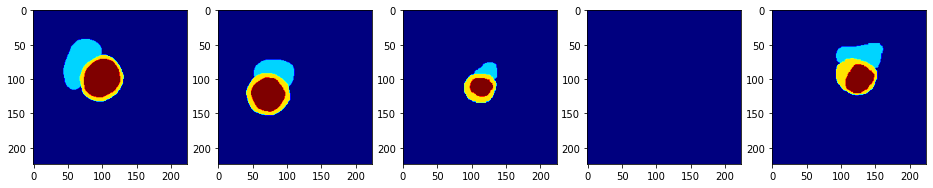

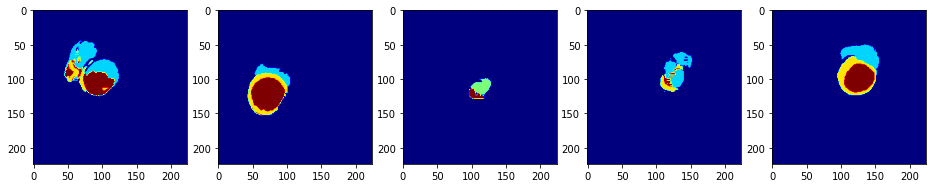

Step 600 (epoch 0)
 - Validation Loss: 0.080024
Step: 605, Loss: 0.091961
Step: 610, Loss: 0.085975
Step: 615, Loss: 0.063658
Step: 620, Loss: 0.074136
Step: 625, Loss: 0.047178
Step: 630, Loss: 0.083299
Step: 635, Loss: 0.066324
Step: 640, Loss: 0.051538
Step: 645, Loss: 0.056554
Step: 650, Loss: 0.081587


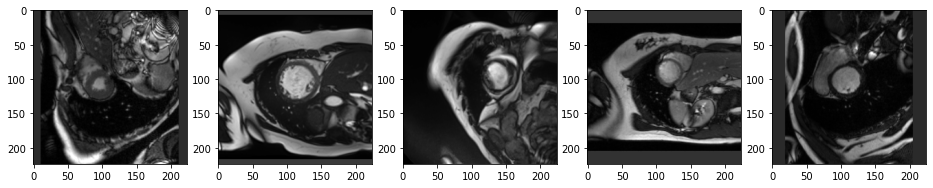

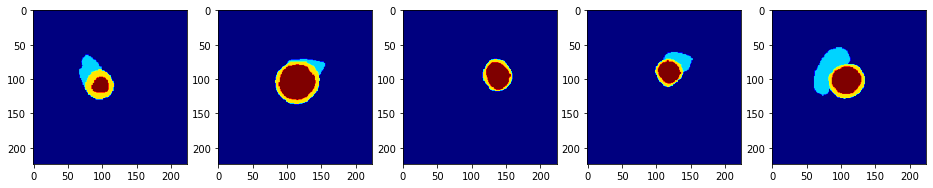

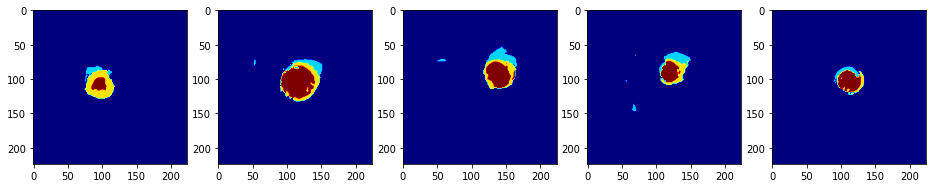

Step: 655, Loss: 0.060909
Step: 660, Loss: 0.047717
Step: 665, Loss: 0.106642
Step: 670, Loss: 0.094497
Step: 675, Loss: 0.101688
Step: 680, Loss: 0.049806
Step: 685, Loss: 0.098531
Step: 690, Loss: 0.095293
Step: 695, Loss: 0.072404
Step: 700, Loss: 0.070474


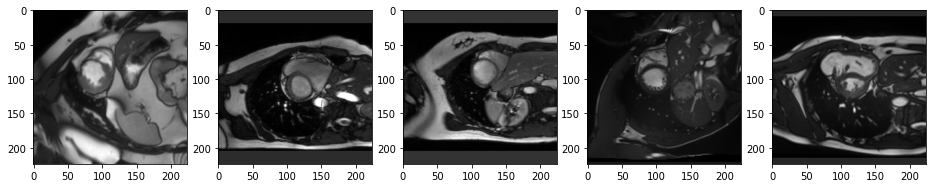

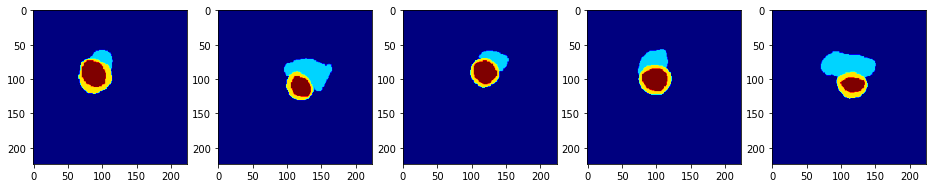

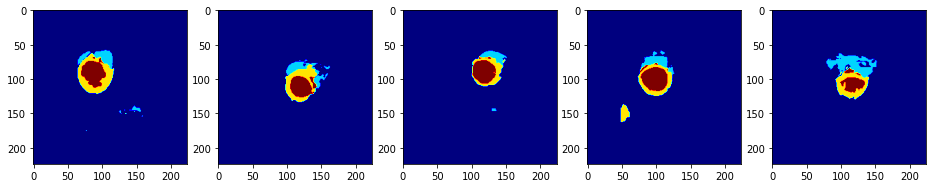

Step 700 (epoch 0)
 - Validation Loss: 0.065752
Step: 705, Loss: 0.057066
Step: 710, Loss: 0.091133
Step: 715, Loss: 0.058963
Step: 720, Loss: 0.074048
Step: 725, Loss: 0.049214
Step: 730, Loss: 0.105543
Step: 735, Loss: 0.077693
Step: 740, Loss: 0.038244
Step: 745, Loss: 0.057247
Step: 750, Loss: 0.060995


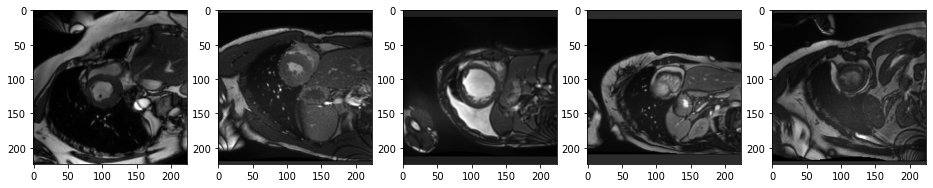

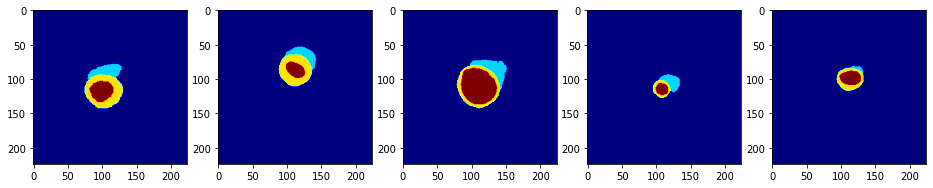

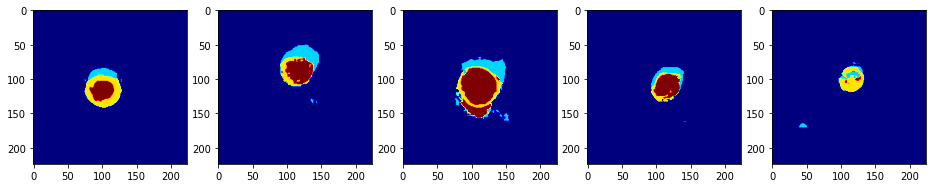

Step: 755, Loss: 0.056687
Step: 760, Loss: 0.052732
Step: 765, Loss: 0.075861
Step: 770, Loss: 0.063741
Step: 775, Loss: 0.045681
Step: 780, Loss: 0.064332
Step: 785, Loss: 0.067027
Step: 790, Loss: 0.054943
Step: 795, Loss: 0.064524
Step: 800, Loss: 0.063599


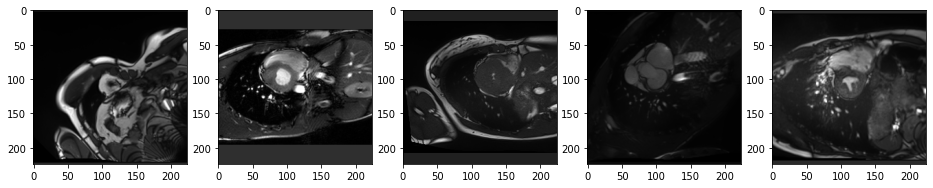

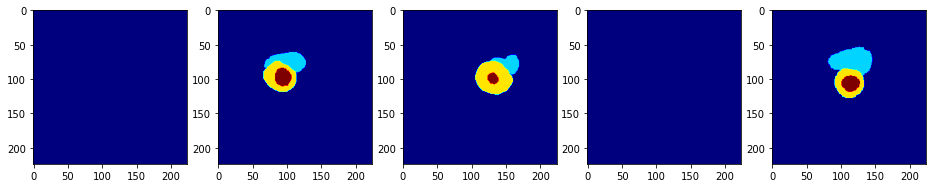

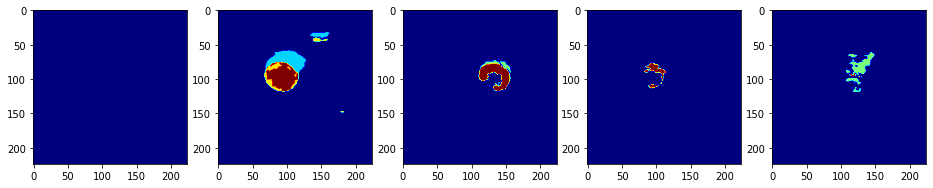

Step 800 (epoch 1)
 - Validation Loss: 0.062201
Step: 805, Loss: 0.046814
Step: 810, Loss: 0.058200
Step: 815, Loss: 0.080860
Step: 820, Loss: 0.067331
Step: 825, Loss: 0.053364
Step: 830, Loss: 0.070993
Step: 835, Loss: 0.049348
Step: 840, Loss: 0.050493
Step: 845, Loss: 0.053454
Step: 850, Loss: 0.042718


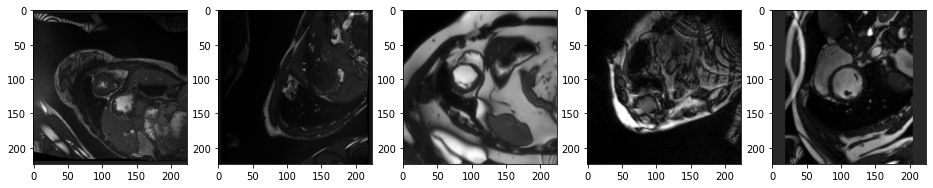

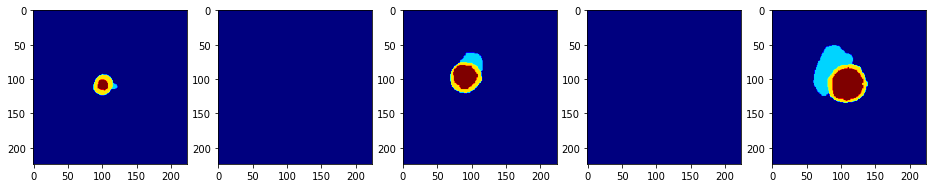

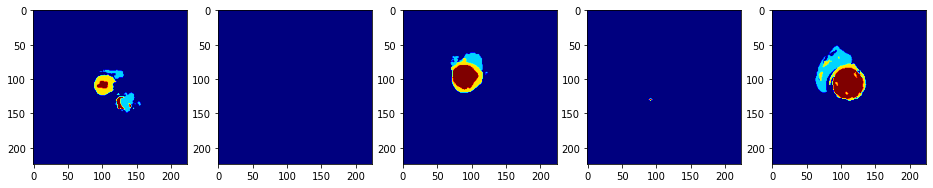

Step: 855, Loss: 0.047513
Step: 860, Loss: 0.077190
Step: 865, Loss: 0.031200
Step: 870, Loss: 0.041172
Step: 875, Loss: 0.064951
Step: 880, Loss: 0.042097
Step: 885, Loss: 0.166631
Step: 890, Loss: 0.040118
Step: 895, Loss: 0.059489
Step: 900, Loss: 0.073240


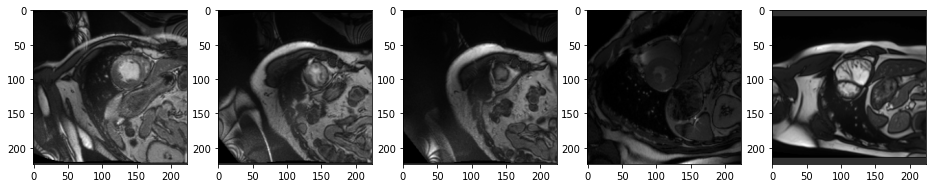

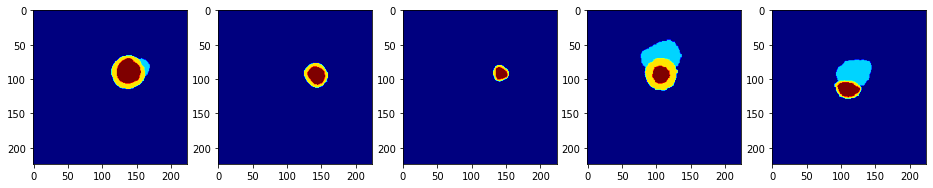

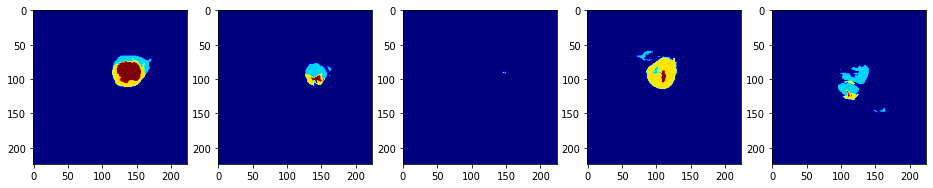

Step 900 (epoch 1)
 - Validation Loss: 0.048938
Step: 905, Loss: 0.030851
Step: 910, Loss: 0.055020
Step: 915, Loss: 0.050001
Step: 920, Loss: 0.030365
Step: 925, Loss: 0.041569
Step: 930, Loss: 0.044790
Step: 935, Loss: 0.052944
Step: 940, Loss: 0.035358
Step: 945, Loss: 0.074779
Step: 950, Loss: 0.044534


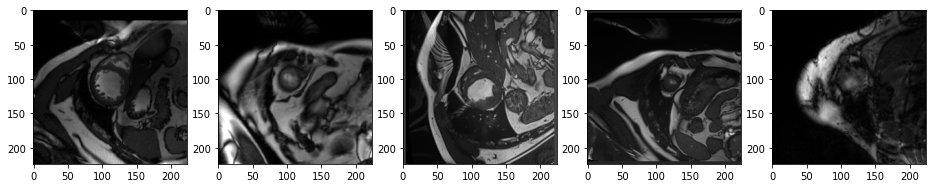

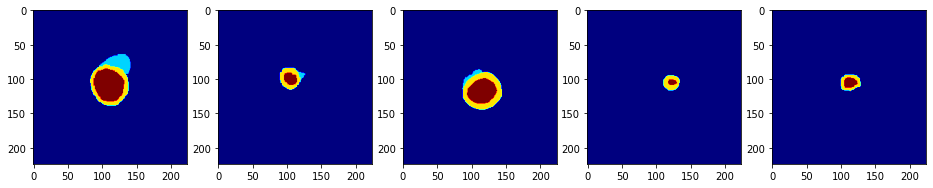

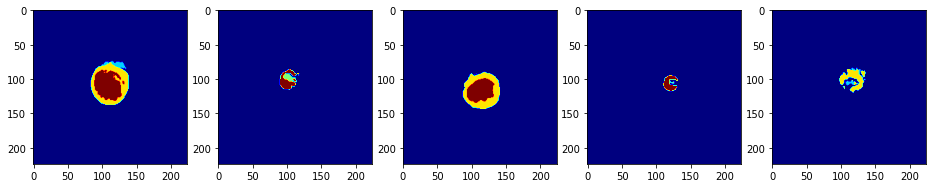

Step: 955, Loss: 0.034424
Step: 960, Loss: 0.045533
Step: 965, Loss: 0.038119
Finished optimisation!


In [15]:
for epoch in range(2):

    for batch in acdc_data.train.iterate_batches(batch_size):  # implement this

        X_b, Y_b = batch
        loss, _ = sess.run([loss_pl, train_op], 
                           feed_dict={X_pl: X_b, Y_pl: Y_b, train_pl: True})  # Plug in the correct variables here

        if step % 5 == 0:
            print('Step: %d, Loss: %f' % (step, loss))
            
        if step % 50 == 0:
            
            # Every 10 steps we plot the predictions with the most recent model on a random
            # sample batch from the validation dataset
            
            X_b, Y_b = acdc_data.validation.next_batch(batch_size)
            output = sess.run(predicted_mask_pl, feed_dict={X_pl: X_b, train_pl: False})

            plot_batch(X_b)
            plot_batch(Y_b, cmap='jet')
            plot_batch(output, cmap='jet')
            
        if step % 100 == 0 and step > 0:  # don't to this for the first step
            
            # Every 10 steps we also evaluate the performance of our network on the entire validation set
            # We also evaluate the performance on the whole training set to identify overfitting. 
            
            val_loss = validate(acdc_data.validation, sess, loss_pl, X_pl, Y_pl, train_pl)
            print('Step %d (epoch %d)' % (step, epoch))
            print(' - Validation Loss: %f' % (val_loss))
            
            # we omit estimating the training loss in the interest of time
            # train_loss = validate(acdc_data.train, sess, loss_pl, X_pl, Y_pl, train_pl)
            # print(' - Training Loss: %f' % (train_loss))
        
        step += 1
        
print("Finished optimisation!")

In [ ]:
sess.close()